<a href="https://colab.research.google.com/github/wallisonferreira/data-science-tce/blob/main/4_regulariza%C3%A7%C3%A3o_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regularização
Agenda
- Propor um modelo
- Usar métodos de regularização na proposição
- Avaliar resultados


Objetivo secundário:
- Otimização de hiperparâmetros

In [1]:
!pip install livelossplot

In [2]:
#keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

#utilitários
import pandas as pd
import numpy as np
import random
import seaborn as sns

#sklearn
import sklearn as sk
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score
from livelossplot import PlotLossesKeras

#balanceamento
#from imblearn.combine import SMOTEENN

#explicabilidade
#import shap


#Passo 1: carregar o dataset

Dataset de exemplo: MNIST - números de 0-9 escritos a mão (https://keras.io/api/datasets/mnist/)
```
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
```

In [3]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)
(60000,)


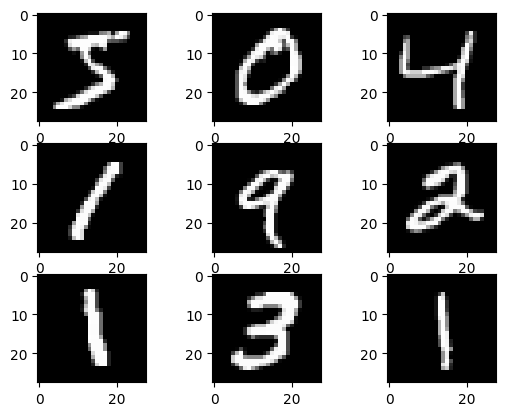

In [4]:
from matplotlib import pyplot

print(x_train.shape)
print(y_train.shape)

for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(x_train[i], cmap='gray')

pyplot.show()

In [5]:
#juntar o treino e teste para poder utilizar no hold-out
X = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])
y = to_categorical(y, 10)

print(X.shape)
print(y.shape)

(70000, 28, 28)
(70000, 10)


In [10]:
#vetorizar a imagem
X = X.flatten().reshape(70000, 28*28)
print(X.shape)

(70000, 784)


#Passo 2: montando o modelo

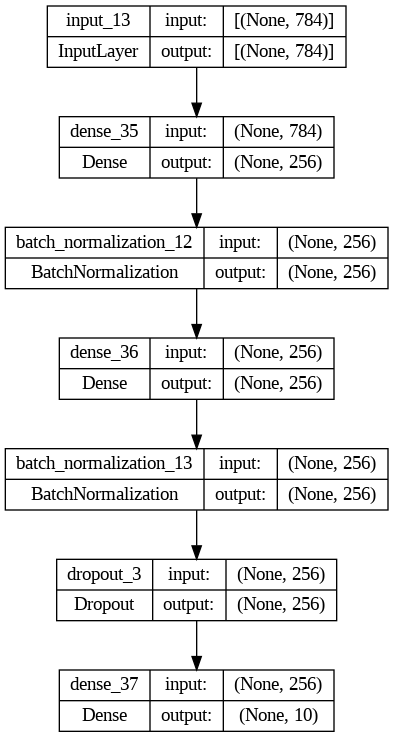

In [23]:
# observar coisas importantes para o futuro: layers.BatchNormalization, layers.Dropout(0.4) não pode ser maior que 50%

def construirModelo(input_shape):
  model = keras.Sequential(
      [layers.Input(shape= input_shape),
       #layers.Dense(256, activation='relu'),
       layers.Dense(256, activation='relu', kernel_regularizer='L2'),
       #layers.BatchNormalization(),
       layers.Dense(256, activation='relu', kernel_regularizer='L2'),
       #layers.BatchNormalization(),
       layers.Dropout(0.35),
       layers.Dense(10, activation='softmax') #igual ao número de classes
      ]
  )


  #especificar: otimizador e função de custo
  model.compile("adam", "categorical_crossentropy",
                metrics=[
                    keras.metrics.CategoricalAccuracy(name='accuracy')],
                )
  return model

model = construirModelo(X.shape[1])
plot_model(model, show_shapes=True)


# Passo 3: Experimento
Hold-Out

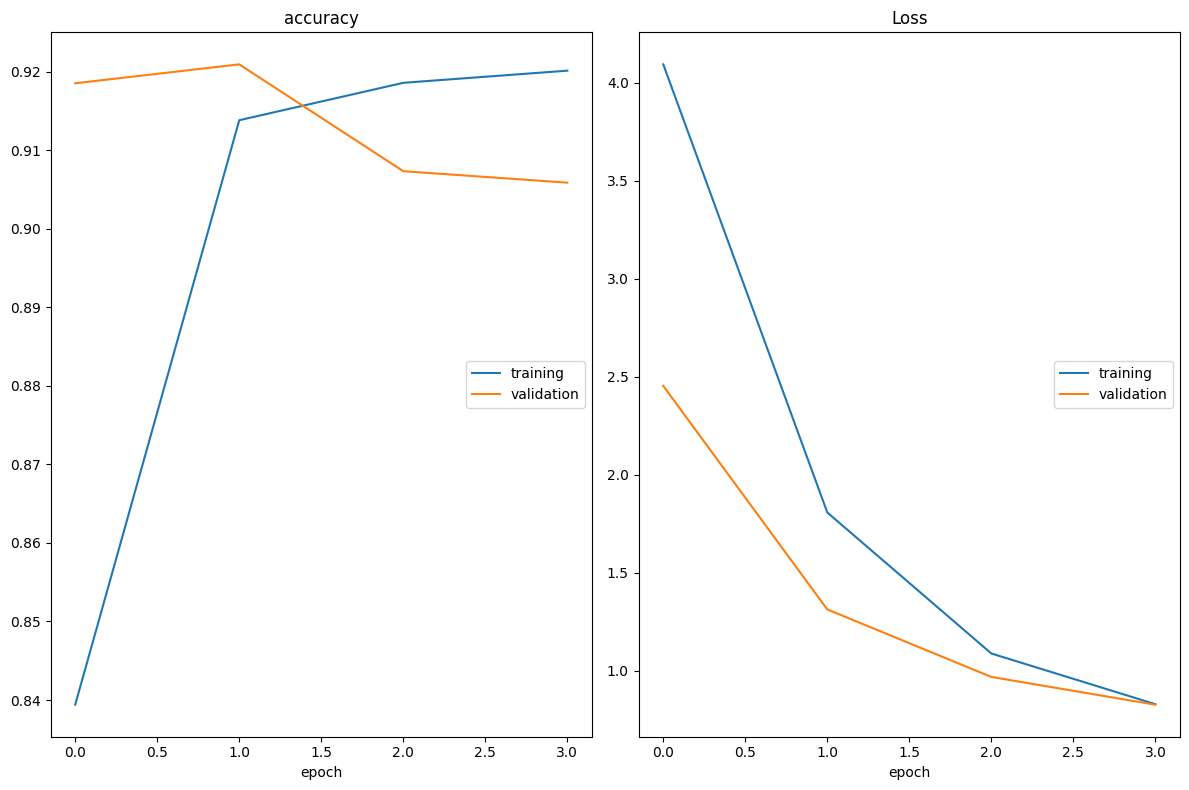

accuracy
	training         	 (min:    0.839, max:    0.920, cur:    0.920)
	validation       	 (min:    0.906, max:    0.921, cur:    0.906)
Loss
	training         	 (min:    0.831, max:    4.094, cur:    0.831)
	validation       	 (min:    0.828, max:    2.454, cur:    0.828)
875/875 [==============================] - 3s 4ms/step
Matriz interação 0:
Recall: 0.9169285714285714 +- 0.0
Precisão: 0.9220493911189745 +- 0.0
F1: 0.9162768828821388 +- 0.0


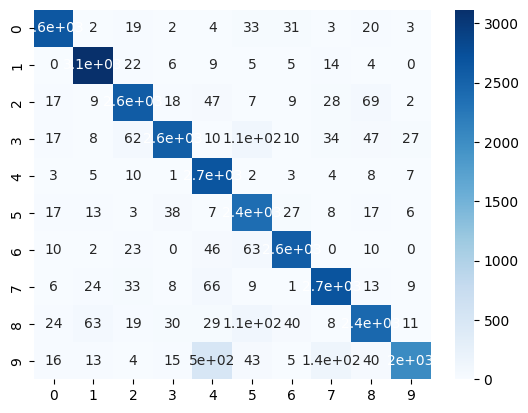

In [25]:
n_runs = 1 #número de execuções
perc_treino = 0.6 #alterei aqui por conta da quantidade de imagens, num teste real aumente
batch_size = 32
epochs = 15

recall = []
prec = []
f1 = []

for i in range(n_runs):

  #pre-requisito
  model = construirModelo(X.shape[1])

  #a) divide a base aleatoriamente
  x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                      train_size=perc_treino,
                                                      random_state = random.randint(1, 1000))
  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                      train_size=0.2, #20% para validação
                                                      random_state = random.randint(1, 1000))

  #early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

  #patience: se não houver melhora em duas épocas, ele para de treinar
  #restore_best_wights: se algo der errado, regride o modelo para os pesos onde estavam melhores
  #com early stop, é bom usar épocas grandes. ex: 100
  early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

  #b) treina
  H = model.fit(
      x_train,
      y_train,
      batch_size= batch_size,
      epochs = epochs,
      callbacks=[PlotLossesKeras(), early], #plotando gráficos
      validation_data = (x_val, y_val))

  #c) predição
  y_pred = model.predict(x_test)
  y_pred = np.argmax(y_pred, axis=1) #apenas a posição que tem a maior probabilidade
  y_true = np.argmax(y_test, axis=1)

  #d) acumula resultados
  recall.append(recall_score(y_true, y_pred, average='weighted', pos_label=1))
  prec.append(precision_score(y_true, y_pred, average='weighted', pos_label=1))
  f1.append(f1_score(y_true, y_pred, average='weighted', pos_label=1))

  matrix = confusion_matrix(y_true, y_pred)
  print("Matriz interação " + str(i) + ":")
  sns.heatmap(matrix, cmap='Blues', annot=True)


#calculando as médias das execuções
recall_media = np.asarray(recall).mean(axis=0)
prec_media = np.asarray(prec).mean(axis=0)
f1_media = np.asarray(f1).mean(axis=0)

#calculando os desvios das execuções
recall_std = np.asarray(recall).std(axis=0)
prec_std = np.asarray(prec).std(axis=0)
f1_std = np.asarray(f1).std(axis=0)

print ("Recall: " + str(recall_media) + " +- " + str(recall_std))
print ("Precisão: " + str(prec_media) + " +- " + str(prec_std))
print ("F1: " + str(f1_media) + " +- " + str(f1_std))



# Passo 4: Um pouco de otimização de hiperparâmetros [Opcional]

Parâmetros atuais da nossa rede?

```
layers.Input(shape= input_shape),
layers.Dense(256, activation='relu'),       
layers.Dense(256, activation='relu')
```

Camadas, ativação, quantidade de neurônios, função de otimização, taxa de aprendizado, modelos de regularização .....

Ver 3 modelos:
 - Random
 - Grid
 - BO - Bayesian optimization
 - Hyperband

 Algumas libs famosas:
 - Keras Tuner: https://keras.io/guides/keras_tuner/getting_started/
 - Optuna: https://optuna.org/



In [26]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.3 MB/s eta 0:00:00


In [27]:
import keras_tuner as kt

In [29]:
def construirModeloParaOtimizar(hp):
  #hiperparâmetros para testar
  unidades_camada_1 = hp.Int('units_c1', min_value=64, max_value=512, step=64)
  unidades_camada_2 = hp.Int('units_c2', min_value=64, max_value=512, step=64)
  taxa_aprendizado  = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) # 0.01, 0.001, 0.0001

  #modelo construído usando uma combinação
  model = keras.Sequential(
      [layers.Input(shape=28*28),
       layers.Dense(units=unidades_camada_1, activation='relu'),
       layers.Dense(units=unidades_camada_2, activation='relu'),
       layers.Dense(10, activation='softmax') #igual ao número de classes
      ]
  )

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=taxa_aprendizado),
                loss = "categorical_crossentropy",
                metrics=[
                    keras.metrics.CategoricalAccuracy(name='accuracy')],
                )
  return model

In [30]:
#instancie o otimizador
#tuner = kt.RandomSearch (1) tentar primeiro
#tuner = kt.GridSearch(
#tuner = kt.BayesianOptimization (2)
#tuner = kt.Hyperband (3)

tuner = kt.Hyperband(construirModeloParaOtimizar,
                     objective='val_accuracy', #maximizar acurácia
                     max_epochs=5,
                     factor=3,
                     directory='estudos_hiper',
                     project_name='hiperband')

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                      train_size=perc_treino,
                                                      random_state = random.randint(1, 1000))
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                      train_size=0.2, #20% para validação
                                                      random_state = random.randint(1, 1000))

tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Trial 10 Complete [00h 00m 42s]
val_accuracy: 0.8874702453613281

Best val_accuracy So Far: 0.924791693687439
Total elapsed time: 00h 03m 26s


In [32]:
#obter o melhor modelo
melhor = tuner.get_best_models(num_models=1)[0] #melhor modelo da primeira posição

melhor.build(input_shape=(None, 28* 28))
melhor.summary()

#lembre-se que o modelo precisa ser retreinado

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 448)               351680    
                                                                 
 dense_1 (Dense)             (None, 448)               201152    
                                                                 
 dense_2 (Dense)             (None, 10)                4490      
                                                                 
Total params: 557322 (2.13 MB)
Trainable params: 557322 (2.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
#obter a trajetória, organizada do melhor para o pior
tuner.results_summary()

Results summary
Results in estudos_hiper/hiperband
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0005 summary
Hyperparameters:
units_c1: 448
units_c2: 448
learning_rate: 0.001
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0004
Score: 0.924791693687439

Trial 0006 summary
Hyperparameters:
units_c1: 512
units_c2: 192
learning_rate: 0.001
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0002
Score: 0.9192559719085693

Trial 0004 summary
Hyperparameters:
units_c1: 448
units_c2: 448
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.9017261862754822

Trial 0009 summary
Hyperparameters:
units_c1: 512
units_c2: 128
learning_rate: 0.0001
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8874702453613281

Trial 0002 summary
Hyperparameters:
units_c1: 512
units_c2: 192
learning_rate: 0.001
tuner/epochs: 2
tu